# 🔬 Tutorial 2: Model Fine-Tuning
## Adapting ESM-2 for Protein Fitness Prediction

---

**Learning Objectives:**
- Load and use pre-trained protein language models (ESM-2)
- Generate protein embeddings for downstream tasks
- Perform zero-shot similarity search
- Fine-tune models with LoRA (Low-Rank Adaptation)
- Predict DMS stability scores using adapted models

---

## 📦 Step 1: Setup and Imports

We'll use:
- **`transformers`**: Load pre-trained ESM models from Hugging Face
- **`peft`**: Apply LoRA adapters for parameter-efficient fine-tuning
- **`torch`**: Deep learning framework for training
- **`scikit-learn`**: Metrics and baseline models

In [5]:
# Core libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Transformers and PEFT
from transformers import AutoTokenizer, AutoModel
from peft import LoraConfig, get_peft_model

# Data processing and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Utilities
import gc
from tqdm.auto import tqdm

# Set style for prettier plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


In [6]:
# Configure compute device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ Using device: {device}")
if torch.cuda.is_available():
    print(f"  GPU: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

✓ Using device: cuda
  GPU: NVIDIA A100-SXM4-40GB
  Memory: 42.29 GB


## 🤖 Step 2: Load Pre-trained ESM Model

We'll use the ESM-2 model from Meta AI/Facebook Research. ESM-2 models are protein language models trained on millions of sequences to understand protein structure and function.

### Available ESM-2 Models

| Model Checkpoint | Layers | Parameters | Best For |
|:-----------------|-------:|-----------:|:---------|
| `esm2_t48_15B_UR50D` | 48 | 15B | Maximum accuracy (requires significant GPU) |
| `esm2_t36_3B_UR50D` | 36 | 3B | High accuracy, large scale |
| `esm2_t33_650M_UR50D` | 33 | 650M | Good balance of accuracy and speed |
| `esm2_t30_150M_UR50D` | 30 | 150M | Medium-sized tasks |
| `esm2_t12_35M_UR50D` | 12 | 35M | Fast experimentation |
| `esm2_t6_8M_UR50D` | 6 | 8M | **Tutorial choice** - fastest training |

💡 **Tip**: Start with smaller models for prototyping, then scale up for production.

In [7]:
# Select model checkpoint (change this to experiment with different sizes)
MODEL_CHECKPOINT = "facebook/esm2_t6_8M_UR50D"  # Smallest ESM-2 model (8M parameters)

print(f"📥 Loading model: {MODEL_CHECKPOINT}")
model = AutoModel.from_pretrained(MODEL_CHECKPOINT).to(device)
model.eval()  # Set to evaluation mode (no training yet)

# Calculate total parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"✓ Model loaded successfully!")
print(f"  Total parameters: {total_params/1e6:.1f} million")
print(f"  Hidden size: {model.config.hidden_size}")
print(f"  Number of layers: {model.config.num_hidden_layers}")

📥 Loading model: facebook/esm2_t6_8M_UR50D


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded successfully!
  Total parameters: 7.8 million
  Hidden size: 320
  Number of layers: 6


## 🔤 Step 3: Understanding the Tokenizer

Protein sequences are represented as strings of single-letter amino acid codes. The **tokenizer** converts these strings into numerical representations that models can process.

**What it does:**
- Converts amino acid letters to numerical token IDs
- Adds special tokens (start, end, padding)
- Handles sequence padding and truncation
- Ensures all sequences in a batch have the same length

In [8]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

print("✓ Tokenizer loaded!")
print(f"  Vocabulary size: {len(tokenizer)}")
print("\n📖 Tokenizer vocabulary:")
print(tokenizer.get_vocab())

✓ Tokenizer loaded!
  Vocabulary size: 33

📖 Tokenizer vocabulary:
{'<cls>': 0, '<pad>': 1, '<eos>': 2, '<unk>': 3, 'L': 4, 'A': 5, 'G': 6, 'V': 7, 'S': 8, 'E': 9, 'R': 10, 'T': 11, 'I': 12, 'D': 13, 'P': 14, 'K': 15, 'Q': 16, 'N': 17, 'F': 18, 'Y': 19, 'M': 20, 'H': 21, 'W': 22, 'C': 23, 'X': 24, 'B': 25, 'U': 26, 'Z': 27, 'O': 28, '.': 29, '-': 30, '<null_1>': 31, '<mask>': 32}


Let's create a visualization of what the tokenizer does.

First, collect the tokenizer vocabulary using the `vocab = tokenizer.get_vocab()` command

In [9]:
# Visualize the tokenizer vocabulary
vocab = tokenizer.get_vocab()

# Separate special tokens from amino acid tokens
special_tokens = {k: v for k, v in vocab.items() if '<' in k or '|' in k}
amino_acid_tokens = {k: v for k, v in vocab.items() if k not in special_tokens and len(k) == 1}


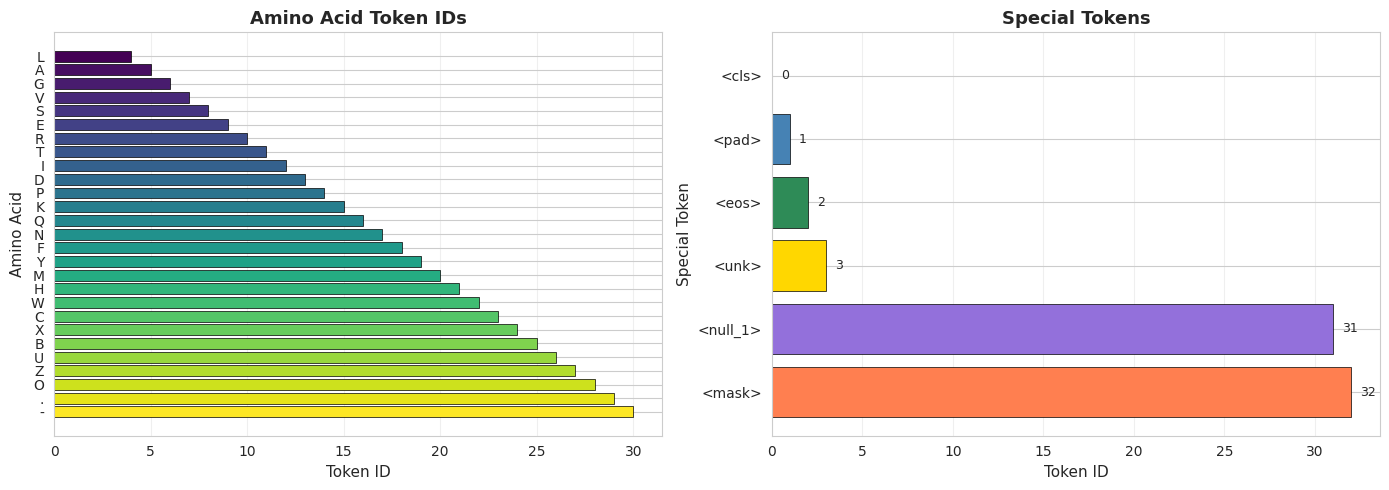


📖 Token Types:
  Amino acids: 27 tokens (standard 20 + variants)
  Special tokens: 6 tokens
  Total vocabulary: 33 tokens

💡 Special Tokens:
  <cls>    (ID  0): Start of sequence marker
  <pad>    (ID  1): Padding token (fills sequences to same length)
  <eos>    (ID  2): End of sequence marker
  <unk>    (ID  3): Unknown token (for invalid amino acids)
  <null_1> (ID 31): Special token
  <mask>   (ID 32): Mask token (for training)


In [10]:

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Amino Acid Token IDs
aa_names = list(amino_acid_tokens.keys())
aa_ids = list(amino_acid_tokens.values())
colors = plt.cm.viridis(np.linspace(0, 1, len(aa_names)))

ax1.barh(aa_names, aa_ids, color=colors, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Token ID', fontsize=11)
ax1.set_ylabel('Amino Acid', fontsize=11)
ax1.set_title('Amino Acid Token IDs', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Plot 2: Special Tokens
special_names = list(special_tokens.keys())
special_ids = list(special_tokens.values())
special_colors = ['coral', 'steelblue', 'seagreen', 'gold', 'mediumpurple']

bars = ax2.barh(special_names, special_ids, color=special_colors[:len(special_names)], 
                edgecolor='black', linewidth=0.5)
ax2.set_xlabel('Token ID', fontsize=11)
ax2.set_ylabel('Special Token', fontsize=11)
ax2.set_title('Special Tokens', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

# Add value labels on special tokens
for i, (name, val) in enumerate(zip(special_names, special_ids)):
    ax2.text(val + 0.5, i, str(val), va='center', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📖 Token Types:")
print(f"  Amino acids: {len(amino_acid_tokens)} tokens (standard 20 + variants)")
print(f"  Special tokens: {len(special_tokens)} tokens")
print(f"  Total vocabulary: {len(vocab)} tokens")

print("\n💡 Special Tokens:")
for name, token_id in special_tokens.items():
    descriptions = {
        '<pad>': 'Padding token (fills sequences to same length)',
        '<eos>': 'End of sequence marker',
        '<unk>': 'Unknown token (for invalid amino acids)',
        '<cls>': 'Start of sequence marker',
        '<mask>': 'Mask token (for training)',
    }
    desc = descriptions.get(name, 'Special token')
    print(f"  {name:8s} (ID {token_id:2d}): {desc}")

### 3.1 Tokenization Example

Let's tokenize a sample protein sequence to see the tokenizer in action.

In [11]:
# Sample protein sequence: Human Insulin
sequence = "MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFYTPKTRREAEDLQVGQVELGGGPGAGSLQPLALEGSLQKRGIVEQCCTSICSLYQLENYCN"

print("Sample sequence (Human Insulin):")
print(f"  Length: {len(sequence)} amino acids")
print(f"  Sequence: {sequence[:50]}...")

Sample sequence (Human Insulin):
  Length: 110 amino acids
  Sequence: MALWMRLLPLLALLALWGPDPAAAFVNQHLCGSHLVEALYLVCGERGFFY...


In [12]:
# Tokenize the sequence
inputs = tokenizer(sequence, return_tensors="pt").to(device)

print("✓ Sequence tokenized!")

✓ Sequence tokenized!


In [13]:
# Examine tokenized output
print(f"Original sequence length: {len(sequence)} amino acids")
print(f"Tokenized input IDs shape: {inputs['input_ids'].shape}")
print(f"Token IDs: {inputs['input_ids'][0][:20]}...")  # Show first 20 tokens

print(f"\n💡 Why is tokenized length different?")
print(f"   The tokenizer adds special tokens like <cls> (start) and <eos> (end)!")

Original sequence length: 110 amino acids
Tokenized input IDs shape: torch.Size([1, 112])
Token IDs: tensor([ 0, 20,  5,  4, 22, 20, 10,  4,  4, 14,  4,  4,  5,  4,  4,  5,  4, 22,
         6, 14], device='cuda:0')...

💡 Why is tokenized length different?
   The tokenizer adds special tokens like <cls> (start) and <eos> (end)!


## 🧬 Step 4: Generating Protein Embeddings

ESM-2 models generate rich vector representations (**embeddings**) that capture structural and functional properties of proteins.

**Two types of embeddings:**
1. **Per-token embeddings**: A vector for each amino acid in the sequence
2. **Pooled embedding**: A single vector representing the entire protein

These embeddings can be used for:
- Similarity search
- Function prediction
- Structure prediction
- Mutation effect prediction

In [14]:
# Generate embeddings for our sample sequence
with torch.no_grad():
    outputs = model(**inputs)

# Extract both types of embeddings
per_token_embeddings = outputs.last_hidden_state
pooled_embedding = outputs.pooler_output

print("✓ Embeddings generated!\n")
print("📊 Per-token Embeddings")
print(f"   Shape: {per_token_embeddings.shape}")
print(f"   → (batch_size, sequence_length, hidden_dim)")
print(f"   → One vector for each amino acid in the sequence\n")

print("📊 Pooled (Whole-Sequence) Embedding")
print(f"   Shape: {pooled_embedding.shape}")
print(f"   → (batch_size, hidden_dim)")
print(f"   → Single vector representing the entire protein")

✓ Embeddings generated!

📊 Per-token Embeddings
   Shape: torch.Size([1, 112, 320])
   → (batch_size, sequence_length, hidden_dim)
   → One vector for each amino acid in the sequence

📊 Pooled (Whole-Sequence) Embedding
   Shape: torch.Size([1, 320])
   → (batch_size, hidden_dim)
   → Single vector representing the entire protein


In [15]:
# Display the pooled embedding
print("Pooled embedding values (first 20 dimensions):")
print(pooled_embedding[0, :20])

Pooled embedding values (first 20 dimensions):
tensor([-0.2569, -0.0801,  0.1524, -0.0038,  0.1577, -0.0641,  0.1289, -0.2892,
         0.0240,  0.0665,  0.0844, -0.0971,  0.1872,  0.0605,  0.0218,  0.2834,
         0.2775,  0.1338, -0.0701,  0.0375], device='cuda:0')


## 🎯 Step 5: Zero-Shot Prediction

The model was trained on masked language modeling (predicting missing amino acids), but the embeddings can be used **directly** for downstream tasks without additional training. This is called **zero-shot learning**.

**Use case**: Find proteins similar in function or structure based on embedding similarity.

### 5.1 Create Reference Database

In [16]:
# Reference database of known proteins with different functions
reference = {
    "Human Lysozyme (Enzyme)": 
        "MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANWMCLAKWESGYNTRATNYNAGDRSTDYGIFQINSRYWCNDGKTPGAVNACHLSCSALLQDNIADAVACAKRVVRDPQGIRAWVAWRNRCQNRDVRQYVQGCGV",
    
    "Human Hemoglobin (Oxygen Transport)": 
        "MVHLTPEEKSAVTALWGKVNVDEVGGEALGRLLVVYPWTQRFFESFGDLSTPDAVMGNPKVKAHGKKVLGAFSDGLAHLDNLKGTFATLSELHCDKLHVDPENFRLLGNVLVCVLAHHFGKEFTPPVQAAYQKVVAGVANALAHKYH",
    
    "Human Keratin (Structural Protein)": 
        "MTTCSRQFTSSSSMKGSCGIGGGIGGGSSRISSVLAGGSCRAPSTYGGGLSVSSSRFSSGGACGLGGGYGGGFSSSSSSFGSGFGGGYGGGLGAGLGGGFGGGFAGGDGLLVGSEKVTMQNLNDRLASYLDKVRALEEANADLEVKIRDWYQRQRPAEIKDYSPYFKTIEDLRNKILTATVDNANVLLQIDNARLAADDFRTKYETELNLRMSVEADINGLRRVLDELTLARADLEMQIESLKEELAYLKKNHEEEMNALRGQVGGDVNVEMDAAPGVDLSRILNEMRDQYEKMAEKNRKDAEEWFFTKTEELNREVATNSELVQSGKSEISELRRTMQNLEIELQSQLSMKASLENSLEETKGRYCMQLAQIQEMIGSVEEQLAQLRCEMEQQNQEYKILLDVKTRLEQEIATYRRLLEGEDAHLSSSQFSSGSQSSRDVTSSSRQIRTKVMDVHDGKVVSTHEQVLRTKN"
}

print(f"✓ Reference database created with {len(reference)} proteins")

✓ Reference database created with 3 proteins


### 5.2 Define Query Protein

In [17]:
# Query protein - which reference protein is it most similar to?
query = {
    "Human Myoglobin (Oxygen Storage)": 
        "MGLSDGEWQLVLNVWGKVEADIPGHGQEVLIRLFKGHPETLEKFDKFKHLKSEDEMKASEDLKKHGATVLTALGGILKKKGHHEAEIKPLAQSHATKHKIPVKYLEFISECIIQVLQSKHPGDFGADAQGAMNKALELFRKDMASNYKELGFQG"
}

print(f"🔍 Query protein: {list(query.keys())[0]}")

🔍 Query protein: Human Myoglobin (Oxygen Storage)


### 5.3 Generate Embeddings for Search

In [18]:
# Generate embeddings for reference database
print("🔄 Generating embeddings for reference database...")
reference_embeddings = {}
with torch.no_grad():
    for name, seq in reference.items():
        ref_inputs = tokenizer(seq, return_tensors="pt").to(device)
        ref_outputs = model(**ref_inputs)
        reference_embeddings[name] = ref_outputs.pooler_output.cpu().numpy()
print(f"✓ Generated {len(reference_embeddings)} reference embeddings")

# Generate embedding for query protein
query_name, query_sequence = next(iter(query.items()))
print(f"\n🔄 Generating embedding for query: {query_name}...")
with torch.no_grad():
    query_inputs = tokenizer(query_sequence, return_tensors="pt").to(device)
    query_outputs = model(**query_inputs)
    query_embedding = query_outputs.pooler_output.cpu().numpy()
print("✓ Query embedding generated")

🔄 Generating embeddings for reference database...
✓ Generated 3 reference embeddings

🔄 Generating embedding for query: Human Myoglobin (Oxygen Storage)...
✓ Query embedding generated


### 5.4 Calculate Similarity Scores

We'll use **cosine similarity** to measure how similar the query protein is to each reference protein.

**Cosine similarity** measures the cosine of the angle between two vectors:
- **1.0**: Identical proteins
- **0.0**: Unrelated
- **-1.0**: Opposite (rare in practice)

In [19]:
# Calculate cosine similarity between query and each reference
similarities = {}
for name, ref_emb in reference_embeddings.items():
    similarity = cosine_similarity(query_embedding, ref_emb)[0][0]
    similarities[name] = similarity

# Find best match
best_match = max(similarities, key=similarities.get)

print("=" * 70)
print(f"🔍 ZERO-SHOT SIMILARITY SEARCH RESULTS")
print("=" * 70)
print(f"\nQuery Protein: {query_name}\n")
print("Similarity Scores (sorted by relevance):")
print("-" * 70)
for name, score in sorted(similarities.items(), key=lambda item: item[1], reverse=True):
    bar = "█" * int(score * 50)
    print(f"{name:45s} {score:.4f} {bar}")

print("\n" + "=" * 70)
print(f"🎯 Best Match: {best_match}")
print(f"   Similarity: {similarities[best_match]:.4f}")
print("=" * 70)
print("\n💡 Myoglobin and Hemoglobin are both oxygen-binding proteins!")

🔍 ZERO-SHOT SIMILARITY SEARCH RESULTS

Query Protein: Human Myoglobin (Oxygen Storage)

Similarity Scores (sorted by relevance):
----------------------------------------------------------------------
Human Hemoglobin (Oxygen Transport)           0.9791 ████████████████████████████████████████████████
Human Keratin (Structural Protein)            0.8990 ████████████████████████████████████████████
Human Lysozyme (Enzyme)                       0.8742 ███████████████████████████████████████████

🎯 Best Match: Human Hemoglobin (Oxygen Transport)
   Similarity: 0.9791

💡 Myoglobin and Hemoglobin are both oxygen-binding proteins!


---

## 🎓 Step 6: Fine-Tuning for Specific Tasks

Zero-shot works well for similarity, but what about predicting specific properties like **protein stability**?

**Goal**: Predict DMS (Deep Mutational Scanning) scores that measure protein fitness.

### 6.1 Load and Prepare Dataset

We'll use the cleaned ProteinGym dataset from Tutorial 1, which contains:
- **Mutated sequences**: Protein variants
- **DMS scores**: Experimental fitness measurements (normalized)

In [20]:
# Load the cleaned dataset from Tutorial 1
DATASET_NAME = "../ProteinGym_DMS_data/cleaned_ProteinGym_DMS_substitutions.csv"

print(f"📂 Loading dataset: {DATASET_NAME}")
dataset = pd.read_csv(DATASET_NAME, usecols=["mut_seq", "score_norm"])

print(f"✓ Dataset loaded successfully!")
print(f"  Total samples: {len(dataset):,}")
print(f"\nFirst few rows:")
dataset.head()

📂 Loading dataset: ../ProteinGym_DMS_data/cleaned_ProteinGym_DMS_substitutions.csv
✓ Dataset loaded successfully!
  Total samples: 2,465,767

First few rows:


,mut_seq,score_norm
0,MRKLSDELLIESYFKCTEMNLNRDFIELIENEIKRRSLGHIISV,1.232103
1,MRKLSDELLIESYFKDTEMNLNRDFIELIENEIKRRSLGHIISV,-0.127580
2,MRKLSDELLIESYFKETEMNLNRDFIELIENEIKRRSLGHIISV,0.949531
3,MRKLSDELLIESYFKFTEMNLNRDFIELIENEIKRRSLGHIISV,1.404415
4,MRKLSDELLIESYFKGTEMNLNRDFIELIENEIKRRSLGHIISV,0.872356


### 6.2 Create Train/Validation/Test Splits

In [21]:
# Configuration
NSAMPLES = 50000  # Samples per split
SEED = 42

# Create random splits
rng = np.random.default_rng(SEED)
random_idxs = rng.choice(len(dataset), len(dataset), replace=False)

train_df = dataset.iloc[random_idxs[:NSAMPLES]]
val_df = dataset.iloc[random_idxs[NSAMPLES:2*NSAMPLES]]
test_df = dataset.iloc[random_idxs[2*NSAMPLES:3*NSAMPLES]]

print("✓ Data split created:")
print(f"  Train set: {len(train_df):,} samples")
print(f"  Validation set: {len(val_df):,} samples")
print(f"  Test set: {len(test_df):,} samples")

✓ Data split created:
  Train set: 50,000 samples
  Validation set: 50,000 samples
  Test set: 50,000 samples


## 📈 Step 7: Baseline - Linear Regression on Frozen Embeddings

**First approach**: Use embeddings from the frozen (unchanged) model and train a simple linear regression on top.

This is fast but limited - the embeddings weren't optimized for our specific task.

### 7.1 Set Random Seeds for Reproducibility

In [22]:
# Set all random seeds for reproducibility
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

print("✓ Random seeds set for reproducibility")

✓ Random seeds set for reproducibility


### 7.2 Create Dataset Class

In [23]:
# Custom PyTorch Dataset for protein sequences
class SequenceDataset(Dataset):
    """
    Dataset class that tokenizes protein sequences on-the-fly.
    """
    def __init__(self, df, tokenizer, max_length=512):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        sequence = row["mut_seq"]
        label = torch.tensor(row["score_norm"], dtype=torch.float32)

        # Tokenize sequence
        inputs = self.tokenizer(
            sequence,
            return_tensors="pt",
            padding="max_length",
            max_length=self.max_length,
            truncation=True,
        )
        # Remove batch dimension
        inputs = {k: v.squeeze(0) for k, v in inputs.items()}
        return inputs, label

print("✓ SequenceDataset class defined")

✓ SequenceDataset class defined


In [24]:
# Create dataset instances
train_dataset = SequenceDataset(train_df, tokenizer)
val_dataset = SequenceDataset(val_df, tokenizer)
test_dataset = SequenceDataset(test_df, tokenizer)

print("✓ Datasets created:")
print(f"  Train: {len(train_dataset):,} samples")
print(f"  Val: {len(val_dataset):,} samples")
print(f"  Test: {len(test_dataset):,} samples")

✓ Datasets created:
  Train: 50,000 samples
  Val: 50,000 samples
  Test: 50,000 samples


### 7.3 Generate Embeddings with Frozen Model

In [25]:
# Configuration
BATCH_SIZE = 512
NUM_WORKERS = 12

print("🔄 Generating embeddings with frozen model...")
print("   This may take a few minutes...\n")

# Generate embeddings for training and test sets
train_embeddings = []
test_embeddings = []

with torch.no_grad():
    # Training embeddings
    print("📊 Processing training set...")
    for batch in tqdm(DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)):
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        train_embeddings.append(outputs.pooler_output.cpu().numpy())
    train_embeddings = np.vstack(train_embeddings)
    print(f"✓ Training embeddings: {train_embeddings.shape}\n")

    # Test embeddings
    print("📊 Processing test set...")
    for batch in tqdm(DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)):
        inputs, labels = batch
        inputs = {k: v.to(device) for k, v in inputs.items()}
        outputs = model(**inputs)
        test_embeddings.append(outputs.pooler_output.cpu().numpy())
    test_embeddings = np.vstack(test_embeddings)
    print(f"✓ Test embeddings: {test_embeddings.shape}\n")

print("✓ All embeddings generated!")

🔄 Generating embeddings with frozen model...
   This may take a few minutes...

📊 Processing training set...


100%|██████████| 98/98 [00:50<00:00,  1.93it/s]


✓ Training embeddings: (50000, 320)

📊 Processing test set...


100%|██████████| 98/98 [00:50<00:00,  1.93it/s]

✓ Test embeddings: (50000, 320)

✓ All embeddings generated!


### 7.4 Train Linear Regression Model

In [26]:
# Train linear regression on frozen embeddings
print("🔄 Training linear regression model...")
linear_model = LinearRegression()
linear_model.fit(train_embeddings, train_df["score_norm"].values)

# Make predictions on test set
test_predictions = linear_model.predict(test_embeddings)

print("✓ Linear model trained!")

🔄 Training linear regression model...
✓ Linear model trained!


### 7.5 Evaluate Baseline Performance

📊 BASELINE MODEL PERFORMANCE (Linear Regression)
Test Mean Squared Error: 0.8980


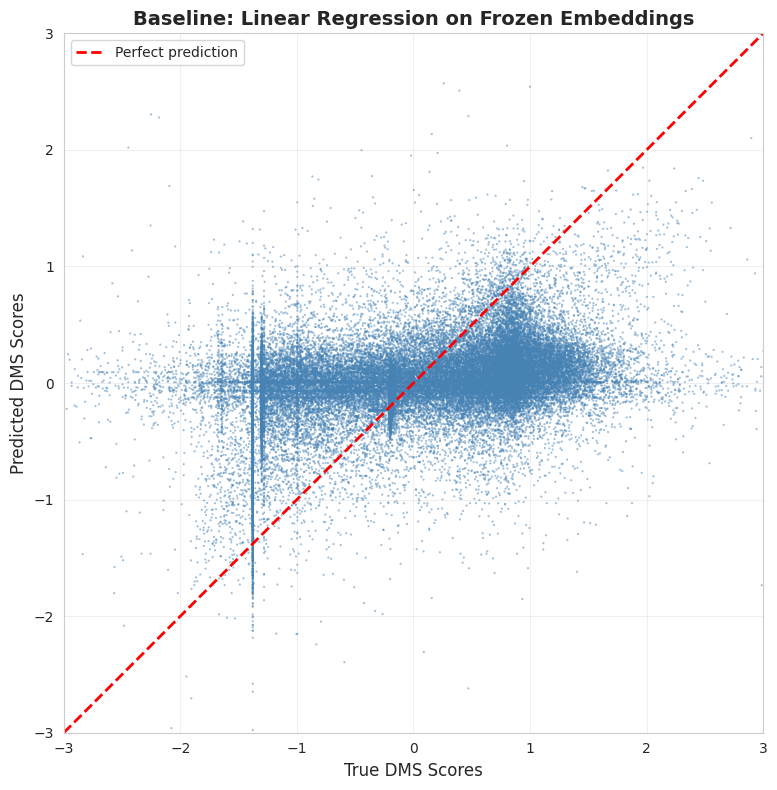


⚠️  Performance is limited because embeddings weren't optimized for this task.


In [27]:
# Calculate performance metrics
mse = mean_squared_error(test_df["score_norm"].values, test_predictions)

print("=" * 60)
print("📊 BASELINE MODEL PERFORMANCE (Linear Regression)")
print("=" * 60)
print(f"Test Mean Squared Error: {mse:.4f}")
print("=" * 60)

# Create visualization
plt.figure(figsize=(8, 8))
plt.scatter(test_df["score_norm"].values, test_predictions, 
            marker='.', alpha=0.5, s=10, color='steelblue', edgecolors='none')
plt.xlabel("True DMS Scores", fontsize=12)
plt.ylabel("Predicted DMS Scores", fontsize=12)
plt.title("Baseline: Linear Regression on Frozen Embeddings", fontsize=14, fontweight='bold')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.plot([-3, 3], [-3, 3], 'r--', linewidth=2, label='Perfect prediction')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n⚠️  Performance is limited because embeddings weren't optimized for this task.")

## 🚀 Step 8: Fine-Tuning with LoRA

The baseline results aren't great because the frozen embeddings weren't optimized for predicting DMS scores.

**Solution**: Fine-tune the model! But training all 8M parameters is expensive...

**LoRA (Low-Rank Adaptation)** to the rescue! 🦸
- Freezes pre-trained weights
- Injects small trainable "adapter" matrices
- Reduces trainable parameters by ~99%
- Much faster and more memory-efficient

### 8.1 Configure LoRA Adapters

**LoRA Parameters:**
- **`r`**: Rank of adapter matrices (lower = fewer parameters)
- **`lora_alpha`**: Scaling factor for adapter updates
- **`target_modules`**: Which layers to adapt (usually attention layers)
- **`lora_dropout`**: Dropout rate for regularization

In [28]:
# Helper function to count trainable parameters
def print_trainable_parameters(model):
    """Count and display trainable vs total parameters."""
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    
    trainable_pct = 100 * trainable_params / all_param
    print(f"  Trainable params: {trainable_params:,}")
    print(f"  Total params: {all_param:,}")
    print(f"  Trainable: {trainable_pct:.2f}%")

# Configure LoRA
lora_config = LoraConfig(
    r=8,                              # Rank (lower = fewer params)
    lora_alpha=32,                    # Scaling factor
    target_modules=["query", "value"], # Adapt attention layers
    lora_dropout=0.1,                 # Regularization
    bias="none",                      # Don't adapt bias terms
)

# Apply LoRA to the model
print("🔄 Applying LoRA adapters to model...\n")
ft_model = get_peft_model(model, lora_config)

print("📊 Model Parameters Comparison:")
print("-" * 60)
print("Before LoRA (original model):")
print_trainable_parameters(AutoModel.from_pretrained(MODEL_CHECKPOINT))
print("\nAfter LoRA (adapted model):")
print_trainable_parameters(ft_model)
print("-" * 60)
print("\n✓ LoRA adapters applied successfully!")

🔄 Applying LoRA adapters to model...

📊 Model Parameters Comparison:
------------------------------------------------------------
Before LoRA (original model):


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  Trainable params: 7,840,121
  Total params: 7,840,121
  Trainable: 100.00%

After LoRA (adapted model):
  Trainable params: 61,440
  Total params: 7,901,561
  Trainable: 0.78%
------------------------------------------------------------

✓ LoRA adapters applied successfully!


### 8.2 Create Regression Model with LoRA

In [29]:
# Training configuration
BATCH_SIZE = 128
NUM_EPOCHS = 10
LEARNING_RATE = 1e-3

# Create custom model with regression head
class RegressionModel(nn.Module):
    """Combines LoRA-adapted ESM model with regression head."""
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model  # LoRA-wrapped model
        self.regressor = nn.Linear(base_model.config.hidden_size, 1)

    def forward(self, **inputs):
        outputs = self.base_model(**inputs)
        pooled_output = outputs.pooler_output
        return self.regressor(pooled_output).squeeze(-1)

# Instantiate the complete model
regression_model = RegressionModel(ft_model).to(device)

print("🎯 Complete Model Architecture:")
print("-" * 60)
print_trainable_parameters(regression_model)
print("-" * 60)

# Create data loaders
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
train_dataset = SequenceDataset(train_df, tokenizer)
val_dataset = SequenceDataset(val_df, tokenizer)
test_dataset = SequenceDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Setup optimizer and loss
optimizer = AdamW(filter(lambda p: p.requires_grad, regression_model.parameters()), lr=LEARNING_RATE)
loss_fn = nn.MSELoss()

print("\n✓ Model and data loaders ready for training!")

🎯 Complete Model Architecture:
------------------------------------------------------------
  Trainable params: 61,761
  Total params: 7,901,882
  Trainable: 0.78%
------------------------------------------------------------

✓ Model and data loaders ready for training!


### 8.3 Training Loop

In [30]:
print("=" * 70)
print("🚀 STARTING LORA FINE-TUNING")
print("=" * 70)
print(f"Configuration:")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Optimizer: AdamW")
print("=" * 70 + "\n")

for ep in range(NUM_EPOCHS):
    # Training phase
    regression_model.train()
    train_loss_sum = 0.0
    
    pbar = tqdm(train_loader, desc=f"Epoch {ep+1}/{NUM_EPOCHS} [Train]", leave=False)
    for inputs, labels in pbar:
        inputs = {k: v.to(device) for k, v in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()
        preds = regression_model(**inputs)
        loss = loss_fn(preds, labels)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    avg_train_loss = train_loss_sum / len(train_loader)
    print(f"Epoch {ep+1}/{NUM_EPOCHS} - Train Loss: {avg_train_loss:.4f}")

print("\n" + "=" * 70)
print("✓ Fine-tuning complete!")
print("=" * 70)

🚀 STARTING LORA FINE-TUNING
Configuration:
  Epochs: 10
  Batch size: 128
  Learning rate: 0.001
  Optimizer: AdamW



Epoch 1/10 - Train Loss: 0.9316


Epoch 2/10 - Train Loss: 0.7541


Epoch 3/10 - Train Loss: 0.6367


Epoch 4/10 - Train Loss: 0.5976


Epoch 5/10 - Train Loss: 0.5729


Epoch 6/10 - Train Loss: 0.5679


Epoch 7/10 - Train Loss: 0.5537


Epoch 8/10 - Train Loss: 0.5447


Epoch 9/10 - Train Loss: 0.5389


Epoch 10/10 - Train Loss: 0.5331

✓ Fine-tuning complete!


### 8.4 Evaluate Fine-Tuned Model

🔄 Evaluating on test set...



Testing: 100%|██████████| 391/391 [00:54<00:00,  7.21it/s]



📊 FINE-TUNED MODEL PERFORMANCE
Test Mean Squared Error: 0.5563
Baseline MSE: 0.8980
Improvement: 38.0% reduction in error


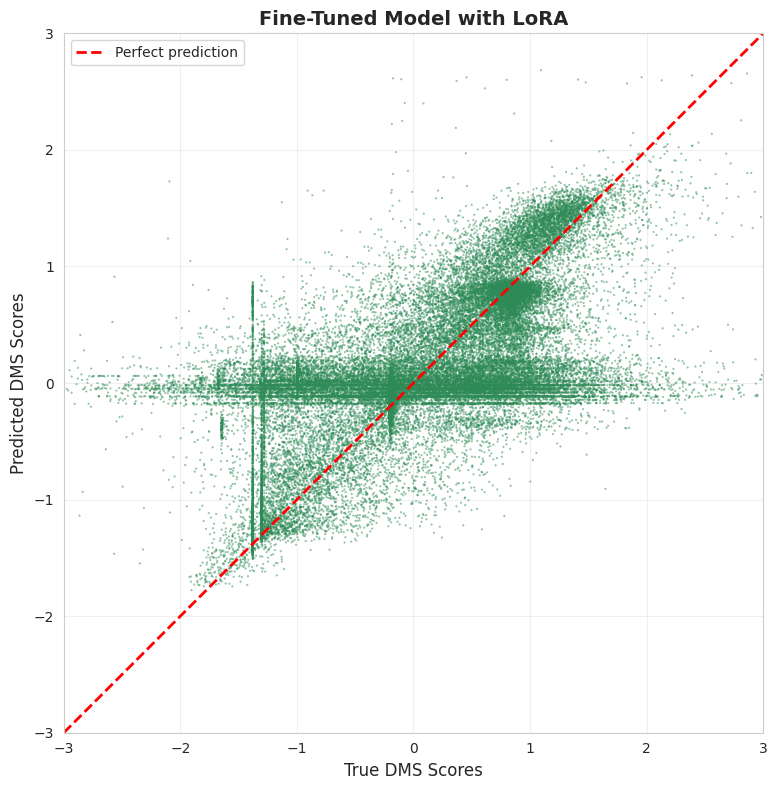


✓ Much better performance after fine-tuning! 🎉


In [31]:
# Evaluate on test set
print("🔄 Evaluating on test set...\n")
regression_model.eval()
test_predictions = []

for inputs, labels in tqdm(test_loader, desc="Testing"):
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        preds = regression_model(**inputs).cpu().numpy()
        test_predictions.extend(preds)
test_predictions = np.array(test_predictions)

# Calculate performance
mse_finetuned = mean_squared_error(test_df["score_norm"].values, test_predictions)

print("\n" + "=" * 70)
print("📊 FINE-TUNED MODEL PERFORMANCE")
print("=" * 70)
print(f"Test Mean Squared Error: {mse_finetuned:.4f}")
print(f"Baseline MSE: {mse:.4f}")
print(f"Improvement: {((mse - mse_finetuned) / mse * 100):.1f}% reduction in error")
print("=" * 70)

# Visualize results
plt.figure(figsize=(8, 8))
plt.scatter(test_df["score_norm"].values, test_predictions, 
            marker='.', alpha=0.5, s=10, color='seagreen', edgecolors='none')
plt.xlabel("True DMS Scores", fontsize=12)
plt.ylabel("Predicted DMS Scores", fontsize=12)
plt.title("Fine-Tuned Model with LoRA", fontsize=14, fontweight='bold')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.plot([-3, 3], [-3, 3], 'r--', linewidth=2, label='Perfect prediction')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Much better performance after fine-tuning! 🎉")

## 🎯 Key Takeaway

Even after just **10 epochs** of fine-tuning, the model's performance improved significantly! With more training and hyperparameter tuning, you can achieve even better results.

**Why LoRA is powerful:**
- ✅ Trains only ~1% of parameters
- ✅ Fast and memory-efficient
- ✅ Prevents catastrophic forgetting
- ✅ Easy to swap different adapters for different tasks

In [32]:
# Clean up GPU memory
print("🧹 Cleaning up GPU memory...")
del model
del ft_model
del regression_model
torch.cuda.empty_cache()
gc.collect()
print("✓ Memory cleaned!")

🧹 Cleaning up GPU memory...
✓ Memory cleaned!


---

## 🎉 Tutorial Complete!

**What we accomplished:**
1. ✅ Loaded and explored pre-trained ESM-2 models
2. ✅ Generated protein embeddings
3. ✅ Performed zero-shot similarity search
4. ✅ Created a baseline with frozen embeddings
5. ✅ Fine-tuned with LoRA for significant improvement

**Next steps to explore:**
- 🔧 Experiment with different LoRA configurations (`r`, `lora_alpha`)
- 📊 Try larger ESM-2 models for better performance
- 🧪 Apply to different protein property prediction tasks
- 🔬 Compare with other fine-tuning strategies
- 📈 Add validation set monitoring and early stopping

**Remember**: This workflow is not limited to biology! The same approach works for:
- Natural language processing
- Computer vision
- Time series analysis
- Any domain with large pre-trained models

---